# Seminar 5 - DCT and MDCT

4 subband FFT filter bank should be comared with FB from Seminar 3.

In [1]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
import copy
import pickle
plt.rcParams['figure.figsize'] = [8,6]

Load audio file

In [2]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


In [3]:
nSubbands = 8

### Task 1: Setting 1

DCT4

DCT via DCT Matrix

In [4]:
def generate_dct_matrix(N):
    n = np.arange(0, N)
    k = np.arange(0, N)
    T = np.zeros((N, N))
    
    for nn in n:
        for kk in k:
            T[nn][kk] = np.sqrt(2.0/N) * np.cos( (np.pi/N) * (nn+0.5) * (kk+0.5))
            
    return T

In [5]:
T = generate_dct_matrix(nSubbands)

# Analysis filterbank (= flipped columns)
fb_a = []
[fb_a.append(np.flipud(T[:, cIdx])) for cIdx in np.arange(nSubbands)]

# Synthesis filterbank (= rows)
fb_s = []
[fb_s.append(T[rIdx, :]) for rIdx in np.arange(nSubbands)]



[None, None, None, None, None, None, None, None]

Plot Frequency Responses

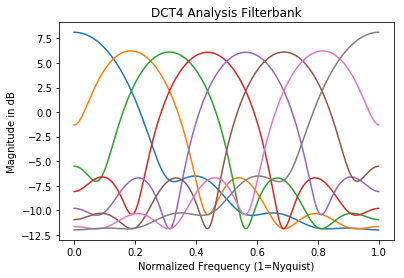

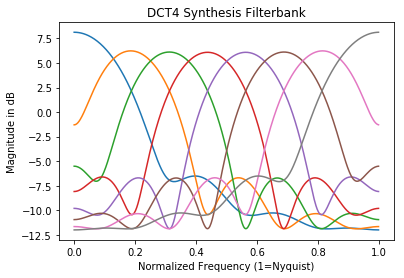

In [6]:
for h in fb_a:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H)))
    plt.title('DCT4 Analysis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')
 
plt.show()

for h in fb_s:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H)))
    plt.title('DCT4 Synthesis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')
    
plt.show()

Use filterbank on audio signal and downsample

In [7]:
decomposed = [np.convolve(h,audio,mode='full') for h in fb_a]
downsampledBands = [s[::nSubbands] for s in decomposed]

Reconstruction:
* upsampling and filtering
* add subbands together

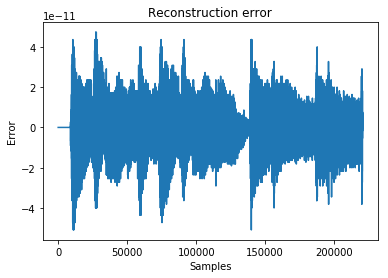

In [8]:
zeroBands = [np.zeros_like(band) for band in decomposed]
usBands = []
for zBand, dsBand in zip(zeroBands, downsampledBands):
    zBand[::nSubbands] = dsBand
    usBands.append(zBand)

filterdUs = [np.convolve(h,band,mode='full') for h,band in zip(fb_s, usBands)]
recon = np.zeros_like(filterdUs[0])
for band in filterdUs:
    recon += band

error = audio - recon[7:-7]
plt.plot(error)
plt.title('Reconstruction error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.show()

In [9]:
print('Play reconstructed audio:')
recon = 32768 * recon / max(abs(recon))
sound.sound(recon,fs)

print('Play original audio:')
audio = 32768 * audio / max(abs(audio))
sound.sound(audio, fs)

Play reconstructed audio:
* done
Play original audio:
* done


In [10]:
wav.write('Setting1_recon.wav', fs, recon)
pickle.dump(downsampledBands, open( "setting1.bin", "wb" ))

### Task 1: Setting 2

DCT4: some subbands set to zero

In [11]:
nSubbandsRemaining = 3
fb_a0 = copy.deepcopy(fb_a)

for i in np.arange(nSubbandsRemaining, nSubbands):
    fb_a0[i] = np.zeros_like(fb_a[i])

Use filterbank on audio signal and downsample

In [12]:
decomposed = [np.convolve(h,audio,mode='full') for h in fb_a0]
downsampledBands = [s[::nSubbands] for s in decomposed]

Reconstruction:
* upsampling and filtering
* add subbands together

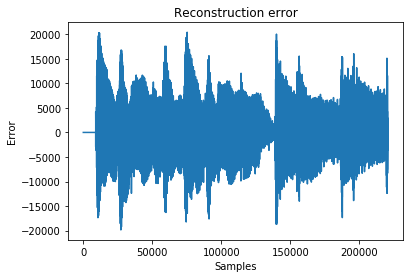

In [13]:
zeroBands = [np.zeros_like(band) for band in decomposed]
usBands = []
for zBand, dsBand in zip(zeroBands, downsampledBands):
    zBand[::nSubbands] = dsBand
    usBands.append(zBand)

filterdUs = [np.convolve(h,band,mode='full') for h,band in zip(fb_s, usBands)]
recon = np.zeros_like(filterdUs[0])
for band in filterdUs:
    recon += band

error = audio - recon[7:-7]
plt.plot(error)
plt.title('Reconstruction error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.show()

In [14]:
print('Play reconstructed audio:')
recon = 32768 * recon / max(abs(recon))
sound.sound(recon,fs)

print('Play original audio:')
audio = 32768 * audio / max(abs(audio))
sound.sound(audio, fs)

Play reconstructed audio:
* done
Play original audio:
* done


In [15]:
wav.write('Setting2_recon.wav', fs, recon)
savebands = downsampledBands[:nSubbandsRemaining]
pickle.dump(savebands, open( "setting2.bin", "wb" ))

### Task 2: Setting 1

MDCT

In [16]:
def Famatrix(h):
    """produces a diamond shaped folding matrix F from the coefficients f
    (h is a row matrix)
    """
    
    N = int(len(h)/2);
    N_2 = int(N/2)
 
    #fliplr:
    h=h[::-1]  
    Fa=np.zeros((N,N,1))
    Fa[0:N_2,0:N_2,0]=-np.fliplr(np.diag(h[0:N_2]))
    Fa[N_2:N,0:N_2,0]=-np.diag(h[N_2:N])
    Fa[0:N_2,N_2:N,0]=-np.diag(h[N:(N+N_2)]) 
    Fa[N_2:N,N_2:N,0]=np.fliplr(np.diag(h[(N+N_2):2*N]))
    
    return Fa

def sinWindow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        s = np.sin(np.pi/N*(n+0.5))
    else:
        s = np.sin(np.pi/(N+1)*(n+1))
    return s

def polmatmult( A,B ):
    """polmatmult(A,B)
    multiplies two polynomial matrices (arrays) A and B, where each matrix entry is a polynomial.
    Those polynomial entries are in the 3rd dimension
    The thirs dimension can also be interpreted as containing the (2D) coefficient
    exponent of z^-1.
    Result is C=A*B;"""
   
    [NAx, NAy, NAz] = np.shape(A);
    [NBx, NBy, NBz] = np.shape(B);

    "Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the..."
    Deg = NAz + NBz -1;
    #initialize (with complex zeros):
    C = np.zeros((NAx,NBy,Deg))#*(1+1j);
    "Convolution of matrices:"
    for n in range(0,(Deg)):
        for m in range(0,n+1):
            if ((n-m)<NAz and m<NBz):
               C[:,:,n] = C[:,:,n]+ np.dot(A[:,:,(n-m)],B[:,:,m]);



    return C

def x2polyphase(x,N):
    """Converts input signal x (a row vector) into a polyphase row vector 
    for blocks of length N"""      

    #Number of blocks in the signal:
    L = int(np.floor(max(np.shape(x))/N))  
    #print("L= ", L)

    xp = np.zeros((1,N,L))
    for m in range(0,L):
        xp[0,:,m] = x[m*N+np.arange(N)]
    return xp

def polyphase2x(xp):
    """Converts polyphase input signal xp (a row vector) into a contiguos row vector
    For block length N, for 3D polyphase representation (exponents of z in the third 
    matrix/tensor dimension)"""
    #Number of blocks in the signal
    [r,N,L] = np.shape(xp);
    x = np.zeros((1,N*L));
    for m in range(L):
        x[0,m*N+np.arange(N)]=xp[0,:,m]
    return x

In [17]:
#Sine Window
h = sinWindow(2*nSubbands)

#Folding Matrix:
Fa=Famatrix(h)

#Delay Matrix D(z):
N_2 = int(nSubbands/2)
Dp = np.zeros((nSubbands,nSubbands,2))
Dp[:,:,0] = np.diag(np.hstack((np.zeros(N_2), np.ones(N_2)))) #z^0
Dp[:,:,1] = np.diag(np.hstack((np.ones(N_2), np.zeros(N_2)))) #z^-1

Faz=polmatmult(Fa,Dp)
T_tensor = np.zeros((nSubbands, nSubbands, 1))
T_tensor[:, :, 0] = T


# H is tensor: H[:,:,0] has the impulse response samples from 0 to nSubbands-1, H[:,:,1] has the impulse response samples
# from nSubbands to nSubbands*2-1 ==> in total the IRs have length 2*nSubbands
H_MDCT = polmatmult(Faz, T_tensor)

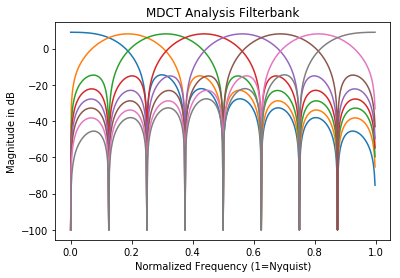

In [18]:
# extract IRs from H for plotting
IR_MDCT = np.vstack((H_MDCT[:,:,1], H_MDCT[:,:,0]))

fb_MDCT = []
# build up MDCT filterbank
[fb_MDCT.append(np.flipud(IR_MDCT[:, column])) for column in np.arange(0,nSubbands)]

for h in fb_MDCT:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H+10e-6)))
    plt.title('MDCT Analysis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')

Filter Audio with MDCT Filterbank

In [19]:
zeropad_audio = np.zeros(int(np.ceil(len(audio)/nSubbands) * nSubbands))
zeropad_audio[:len(audio)] = audio

xp = x2polyphase(zeropad_audio,nSubbands)
yp=polmatmult(xp,H_MDCT)

Synthesis with MDCT

In [20]:
# Invert analysis folding matrix to get synthesis folding matrix
Fs=np.zeros(Fa.shape)
Fs[:,:,0]=np.linalg.inv(Fa[:,:,0])

#Inverse Delay Matrix with delay:
Dpi=np.zeros((nSubbands,nSubbands,2))
Dpi[:,:,1]=np.diag(np.hstack((np.zeros(N_2),np.ones(N_2))))
Dpi[:,:,0]=np.diag(np.hstack((np.ones(N_2),np.zeros(N_2))))

G_MDCT = polmatmult(polmatmult(T_tensor, Dpi), Fs)

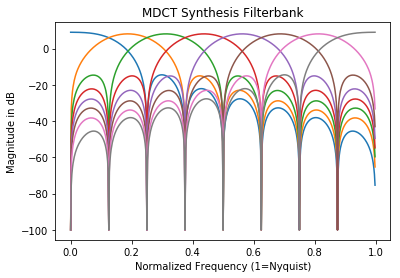

In [21]:
# extract IRs from G for plotting
IR_iMDCT = np.hstack((G_MDCT[:,:,0], G_MDCT[:,:,1]))

fb_iMDCT = []
# build up MDCT filterbank
[fb_iMDCT.append(IR_iMDCT[row, :]) for row in np.arange(0,nSubbands)]

for h in fb_iMDCT:
    W,H = sig.freqz(h)
    plt.plot(W/(np.pi),20*np.log10(np.abs(H+10e-6)))
    plt.title('MDCT Synthesis Filterbank')
    plt.xlabel('Normalized Frequency (1=Nyquist)')
    plt.ylabel('Magnitude in dB')

In [22]:
#Multiply with synthesis matrix G:
xrekp=polmatmult(yp,G_MDCT)
xrek=polyphase2x(xrekp)

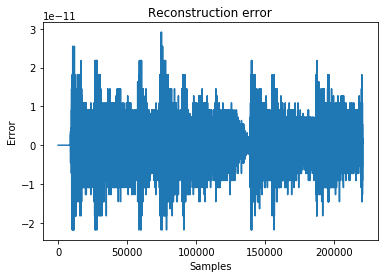

In [23]:
recon_mdct = xrek[0]

plt.plot(recon_mdct[nSubbands:-8] - zeropad_audio)
plt.title('Reconstruction error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.show()


In [24]:
sound.sound(recon_mdct, fs)

* done


### Task 2: Setting 2

MDCT: some subbands set to zero

In [25]:
nSubbandsRemaining = 3
H_MDCT0 = copy.deepcopy(H_MDCT)
H_MDCT0[:, nSubbandsRemaining:, :] = 0

yp0=polmatmult(xp,H_MDCT0)
xrekp0=polmatmult(yp0,G_MDCT)
xrek0=polyphase2x(xrekp0)

In [26]:
recon_mdct0 = xrek0[0]

In [28]:
sound.sound(recon_mdct0, fs)

* done


### Check for Task 3

In [40]:
import sympy

z = sympy.symbols('z')
H = sympy.Matrix([[z**(-1), 2], [3*z**(-1), 4]])
print (H**-1)

print(H * H**(-1))

Matrix([[-2*z, z], [3/2, -1/2]])
Matrix([[1, 0], [0, 1]])
